# Bus AVL Project

Ehab Ebeid

## Setup

In [1]:
from __future__ import division, print_function
import numpy as np, pprint
import matplotlib.pyplot as plt
import math

## Data Exploration

The dataset can be very large. First, set the parameters used to specify which data to import.

In [2]:
# minimum and maximum trip start datetime, in the format "yyyy-mm-dd hh:mi:ss", local time
FROM_DT = '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 12:00:00'

# a single route pattern, which encodes the bus route and direction
ROUTE_PATTERN = '7901'

The AVL data is located in a local Microsoft SQL Server database. Connect to the database and import a selection of the data using the parameters above.

In [3]:
import pyodbc 
import pandas as pd

def get_data(from_dt, to_dt, route_pattern):
    # connect to local database
    cnxn = pyodbc.connect(Trusted_Connection='yes', 
                          driver = '{SQL Server}',
                          server = 'EHAB\SQLEXPRESS', 
                          database = 'raw_nav')
    
    # join the tables route_run and gps_reading, using the filters specified above
    query = """select 
                r.id as route_run_id,
                r.route_pattern,
                r.bus_id,
                r.svc_date,
                r.trip_start_datetime,
                g.id as gps_reading_id,
                g.lat_fixed as lat,
                g.lon_fixed as lon,
                g.heading_deg,
                g.door_state,
                g.vehicle_state,
                g.odo_feet,
                g.time_seconds,
                g.sat_count,
                g.stop_window_data,
                r.invalid

            from raw_nav.dbo.route_run as r
            join raw_nav.dbo.gps_reading as g
            on r.id = g.route_run_id

            where trip_start_datetime between '{start}' and '{end}'
              and route_pattern = '{pattern}'
            ;
            """.format(start=from_dt, end=to_dt, pattern=route_pattern)

    # grab as a pandas dataframe
    return pd.read_sql_query(query, cnxn)

        
df = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)

Let's take a look!

In [4]:
# summarise the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13962 entries, 0 to 13961
Data columns (total 16 columns):
route_run_id           13962 non-null int64
route_pattern          13962 non-null object
bus_id                 13962 non-null object
svc_date               13962 non-null object
trip_start_datetime    13962 non-null datetime64[ns]
gps_reading_id         13962 non-null int64
lat                    13962 non-null float64
lon                    13962 non-null float64
heading_deg            13962 non-null int64
door_state             13962 non-null object
vehicle_state          13962 non-null object
odo_feet               13962 non-null int64
time_seconds           13962 non-null int64
sat_count              13962 non-null int64
stop_window_data       348 non-null object
invalid                13962 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(6)
memory usage: 1.7+ MB


In [5]:
# first five rows
df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0


It would be useful to see how many route runs, or trips, are included in the data.

In [6]:
ntrips = df.trip_start_datetime.unique().shape
print (ntrips)

(10,)


This is the number of trips with start times given by the parameters above.

It would be useful to plot them out as time-space diagrams. Doing so is easiest with timestamps for each GPS reading, which we are missing. Instead we have the `time_seconds` field, which is the number of seconds elapsed since the start of the trip. Let's create a `timestamp` field.

In [7]:
def add_timestamps(df):
    df['timestamp'] = df.trip_start_datetime + pd.to_timedelta(df['time_seconds'], unit='s')
    return df

df = add_timestamps(df)

df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid,timestamp
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0,2018-06-13 10:12:30
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0,2018-06-13 10:12:31
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0,2018-06-13 10:12:32
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0,2018-06-13 10:12:32
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0,2018-06-13 10:12:32


That's more like it! Now we can plot the trips.

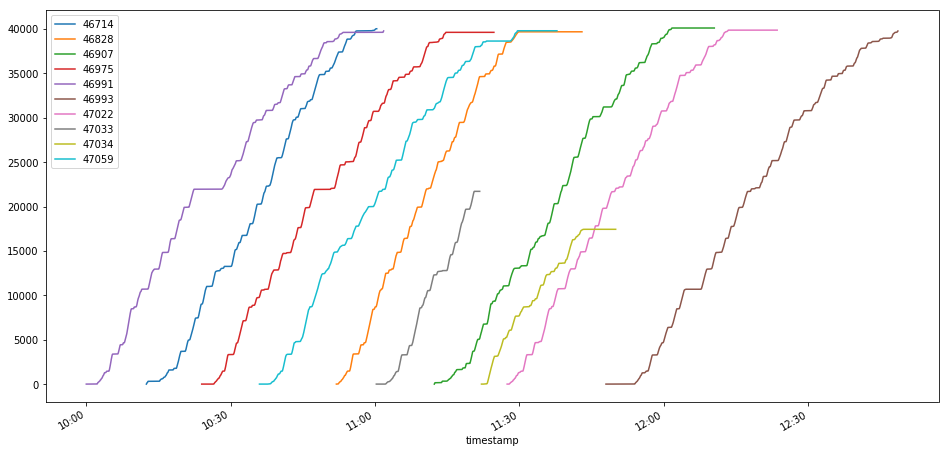

In [8]:
import matplotlib.dates as mdates

# time-space diagrams of the trips returned
fig, ax = plt.subplots()
for name, group in df.groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

We notice that most trips have approximately the same maximum odometer reading, at around 40,000 feet. This is to be expected since they are all on the same route and direction.

**However**, two trips stand out as erroneous: route run 47033 (grey) and 47034 (light green) are shorter than the others. Because route run 47034 starts at around the same time that 47033 ends, it is reasonable to conclude that this is a case of the bus odometer resetting to zero mid-trip. This is by far the most common case of erroneous data.

<div class='tableauPlaceholder' id='viz1546091739629' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='views&#47;BusAVL&#47;Dashboard?:embed=y&amp;:display_count=y&amp;publish=yes' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1546091739629');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='527px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Data Cleaning

### Remove trips with odometer resets to zero

In [9]:
def remove_short_trips(df, display=True):
    df_cleaned = df.copy()
    # calculate median odometer reading m
    max_odos = {}
    if display:
        print("trip  max odo")
    
    for name, group in df_cleaned.groupby('route_run_id'):
        max_odo = group['odo_feet'].max()
        if display:
            print(name, max_odo)
        max_odos[name] = max_odo

    max_odo_values = list(max_odos.values())
    m = np.median(max_odo_values)

    
    # mark trips with odometer readings of >1.05m or <0.95m
    for i, row in df_cleaned.iterrows():
        if max_odos[row['route_run_id']] > 1.05*m or max_odos[row['route_run_id']] < 0.95*m:
            df_cleaned.at[i,'invalid'] = 1
    
    print()
    print("Median =", m)
    
    return df_cleaned

df_cleaned = remove_short_trips(df)

trip  max odo
46714 40027
46828 39681
46907 40108
46975 39621
46991 39778
46993 39771
47022 39869
47033 21710
47034 17435
47059 39800

Median = 39774.5


In [10]:
df_cleaned.to_csv("bus_avl_cleaned.csv")

In [11]:
#TODO: Other data cleaning (?)

Let us check now if the problematic trips have been removed.

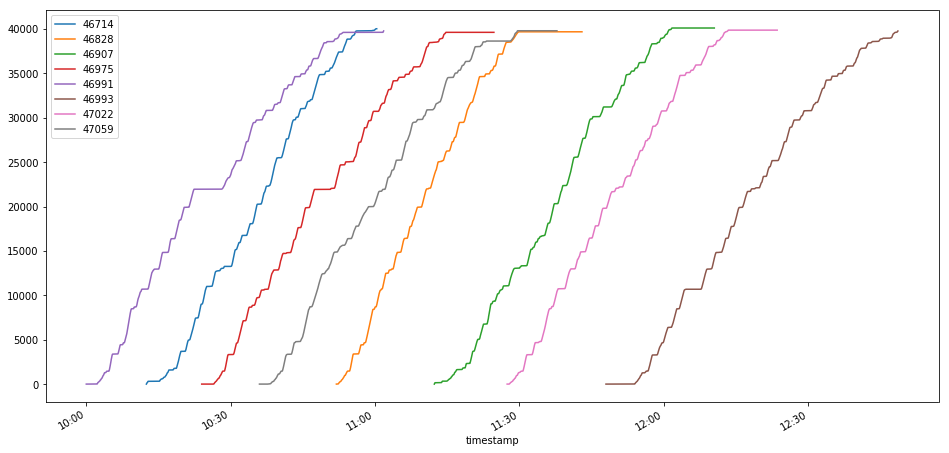

In [12]:
fig, ax = plt.subplots()
for name, group in df_cleaned.loc[df_cleaned['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

Running the same steps on the entire day's data will let us know if this data cleaning task is successful.

In [13]:
FROM_DT = '2018-06-13 00:00:00' # '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 23:59:59' # '2018-06-13 12:00:00'

df_all = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)
df_all = add_timestamps(df_all)

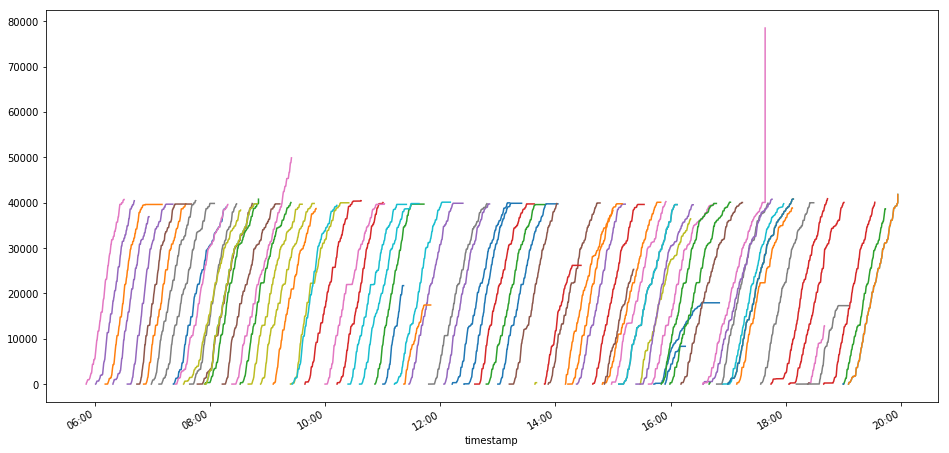

In [14]:
fig, ax = plt.subplots()
for name, group in df_all.loc[df_all['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

In [15]:
df_all_cln = remove_short_trips(df_all, display=False)


Median = 39746.0


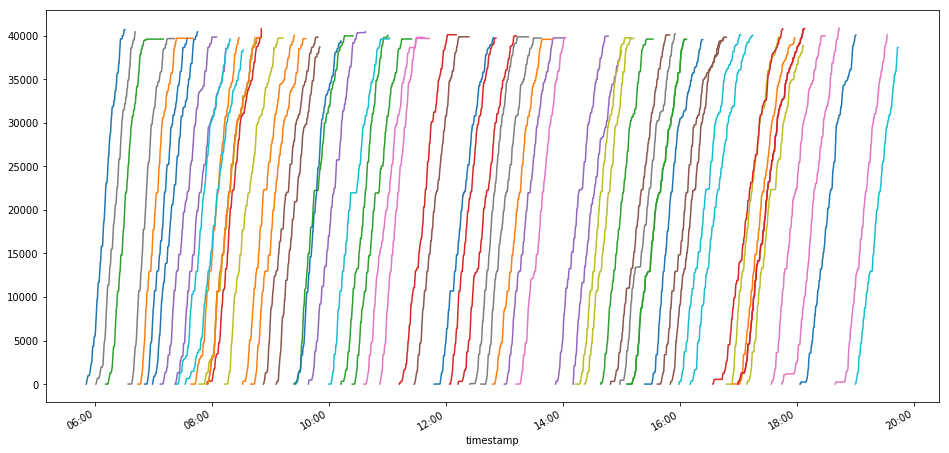

In [16]:
fig, ax = plt.subplots()
for name, group in df_all_cln.loc[df_all_cln['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

What a beauty! No more strange trips as far as I can tell.

## Analysis

In [17]:
from datetime import datetime
def ts_diff(ts1, ts2):
    """Returns diff in float minutes between
    ts1 and ts2, both in format 'yyyy-mm-dd hh:mi:ss', 
    e.g. '13/06/2018 10:12'
    """
    d1 = datetime.strptime(ts1, '%d-%m-%Y %H:%M:%S')
    d2 = datetime.strptime(ts2, '%d-%m-%Y %H:%M:%S')
    return (abs(d2-d1).total_seconds()/60)

### Segment Analysis

In [18]:
segments = {}
for name, group in df_all_cln.loc[df_all_cln['invalid'] == 0].groupby('route_run_id'):
    on = False
    segment = {}
    last_window = 0
    stationary = False
    door_open = False
    st_secs = 0
    open_secs = 0
    
    for i, row in group.iterrows():
        if row['stop_window_data'] == 'E02':
            # avoid start of trip
            on = True
            last_window = 2 # last window entrance code
            
        if on:
            if row['stop_window_data']:
                # segment ID
                if row['stop_window_data'][0] == 'E':
                    # entering stop window
                    # segment that just ended is pre stop
                    last_window = int(row['stop_window_data'][1:])
                    segment_id = str(last_window)+"P"
                    
                elif row['stop_window_data'][0] == 'X':
                    # exiting stop window
                    # segment that just ended is stop
                    segment_id = str(last_window)+"S"
                
                if segment: # check if segment dict is not empty
                    # end previous segment
                    segment['out_ts'] = prev_row['timestamp']
                    segment['duration_secs'] = (segment['out_ts'] - segment['in_ts']).total_seconds()
                    segment['out_odo'] = int(prev_row['odo_feet'])
                    segment['dist_feet'] = segment['out_odo'] - segment['in_odo']
                    
                    segment['stationary_secs'] = st_secs
                    segment['door_open_secs'] = open_secs
                    
                    # identify errors
                    if segment['duration_secs'] > 10 and segment['dist_feet'] > 10:
                        #speed calculation here to avoid division by zero
                        segment['avg_speed_ftps'] = segment['dist_feet']/segment['duration_secs']
                        
                        # add segment to dict
                        if not segments.get(segment_id):
                            segments[segment_id] = []
                        segments[segment_id].append(segment)

                # start new segment
                st_secs = 0
                open_secs = 0
                segment = {}
                segment['in_ts'] = row['timestamp']
                segment['bus_id'] = row['bus_id']
                segment['route_run_id'] = row['route_run_id']
                segment['in_ts'] = row['timestamp']
                segment['in_odo'] = int(row['odo_feet'])
                
            # count seconds with open door
            if stationary:
                secs_since_prev = int(row['time_seconds']) - int(prev_row['time_seconds'])
                st_secs += secs_since_prev
            stationary = True if row['vehicle_state'] == 'S' else False
                
            # count seconds with stationary vehicle
            if door_open:
                secs_since_prev = int(row['time_seconds']) - int(prev_row['time_seconds'])
                open_secs += secs_since_prev
            door_open = True if row['door_state'] == 'O' else False
            
        prev_row = row

In [19]:
pp = pprint.PrettyPrinter()
pp.pprint(segments["3P"][0])

{'avg_speed_ftps': 28.548148148148147,
 'bus_id': '6451',
 'dist_feet': 3854,
 'door_open_secs': 0,
 'duration_secs': 135.0,
 'in_odo': 4758,
 'in_ts': Timestamp('2018-06-13 06:57:26'),
 'out_odo': 8612,
 'out_ts': Timestamp('2018-06-13 06:59:41'),
 'route_run_id': 46710,
 'stationary_secs': 0}


In [20]:
segment_durations = {}
segment_dists = {}
segment_speeds = {}
segment_door_open = {}
segment_stationary = {}
for key, segment_list in segments.items():
    for run in segment_list:
        if not segment_durations.get(key):
            segment_durations[key] = []
        segment_durations[key].append(run['duration_secs'])
        
        if not segment_dists.get(key):
            segment_dists[key] = []
        segment_dists[key].append(run['dist_feet'])
        
        if not segment_speeds.get(key):
            segment_speeds[key] = []
        segment_speeds[key].append(run['avg_speed_ftps'])
        
        if not segment_door_open.get(key):
            segment_door_open[key] = []
        segment_door_open[key].append(run['door_open_secs'])
        
        if not segment_stationary.get(key):
            segment_stationary[key] = []
        segment_stationary[key].append(run['stationary_secs'])

In [120]:
def show_segment_hists(segment_dict, name, units=""):
    size = len(segment_dict)
    rows = math.ceil(size/2) # of rows
    sbwidth = 15
    sbheight = sbwidth*5
    f, axarr = plt.subplots(rows, 2, figsize = (sbwidth, sbheight))
    r = 0
    c = 0

    for key, l in segment_dict.items():
        max_l = max(l)
        norm_l = [i/max_l*100 for i in l]

        #create title
        stop_n = key[:-1]
        if key[-1] == "S":
            title = "Stop " + stop_n
                    
            color = "firebrick"
        else:
            title = "Segment Between Stops " + str(int(stop_n)-1) + " and " + stop_n
            color = "darkblue"
            
        # add mean and median below title
        title = title + "\n mean=" +\
                "{:.1f}".format(np.mean(l)) +\
                ", median=" + "{:.1f}".format(np.median(l)) +\
                ", sd=" + "{:.2f}".format(np.std(l))

        #plot!
        ax = axarr[r, c]
        ax.set_title(title)
        
        if int(max_l/22) > 0:
            step = int(max_l/22)
        else:
            step = 1
        
        ax.hist(norm_l, color=color, bins = range(0,110,5), align="left")
        # ax.hist(l, color=color, bins = range(0,int(1.1*max_l),step), align="left")
        ax.set_xlabel(name + " % of " + str(int(max_l)) + " " + units + "\n")
        # ax.set_xlabel(name + " (" + units + ")\n")
        ax.set_ylabel("Number of Runs")

        if c == 1: r += 1
        if c == 0: c = 1
        else: c = 0

    f.subplots_adjust(hspace=.35, wspace=.2)

### Distance

This marks the distance covered by the bus through each segment, as calculated through the bus odometer.

As expected the distance in the non-stop segments is fairly consistent, confirming that the stop windows are a consistent way of dividing the routes.

For the segments containing stops, however, they are marked by a fair degree of variation, indicating that there is a bit of inconsistency in when the flags marking entries into and exits out of a stop window is raised.

Distance of the segment around stop 16 is all over the place! This makes sense as the AVL system often does not know when to mark the end of a trip properly.

I am not entirely sure why there are so many outliers for stop 2 and stop 3.

**TODO**  
I need to figure out whether or not to exclude some segment runs based on their distance being an outlier. Stop 16 should most definitely be excluded.

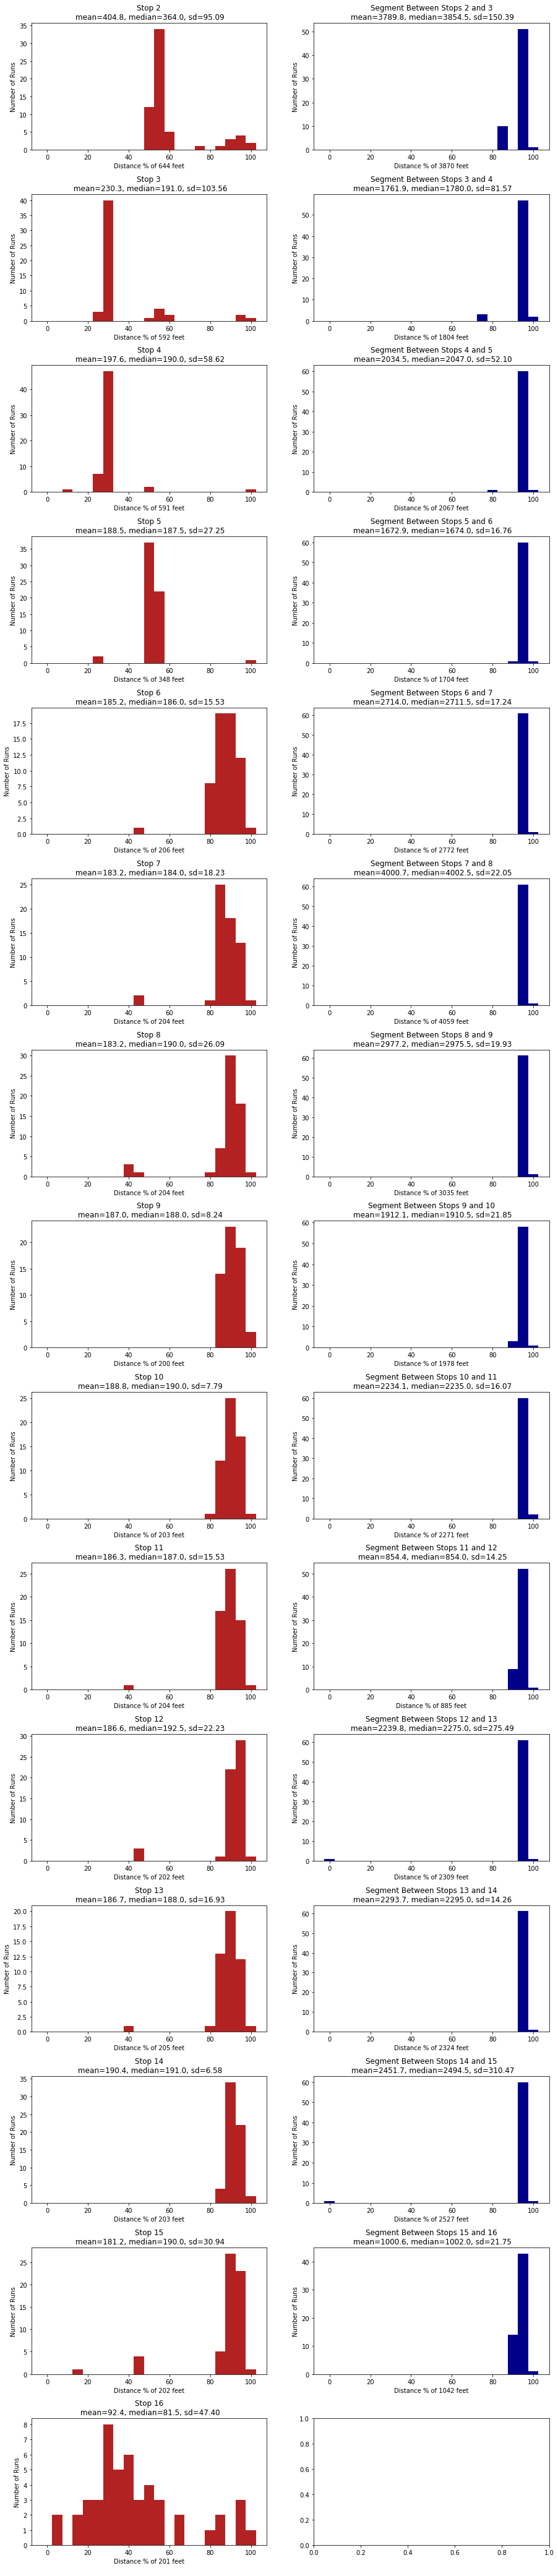

In [121]:
show_segment_hists(segment_dists, "Distance", "feet")

### Duration

This marks the duration of time passed through each segment run as calculated by the bus's seconds counter.

The histograms seem to be largely normally distributed, with some tails towards the longer (more time-consuming) ends. Some segments, for example before the segment between stops 9 and 10, seem to be bimodal. Perhaps another factor, such as peak/off-peak, is a predictor of which of the two modes a segment run belongs to?

The time spent in the stop windows is on average less than the time spent between them. This being said, the difference is not large and as such the average speed within the stop window is expected to be smaller, as the stop windows constitute a comparatively shorter distance than the segments between stops. The speed analysis, which is next, will elaborate on that.

Stop 16 is really funky. We can exclude it.

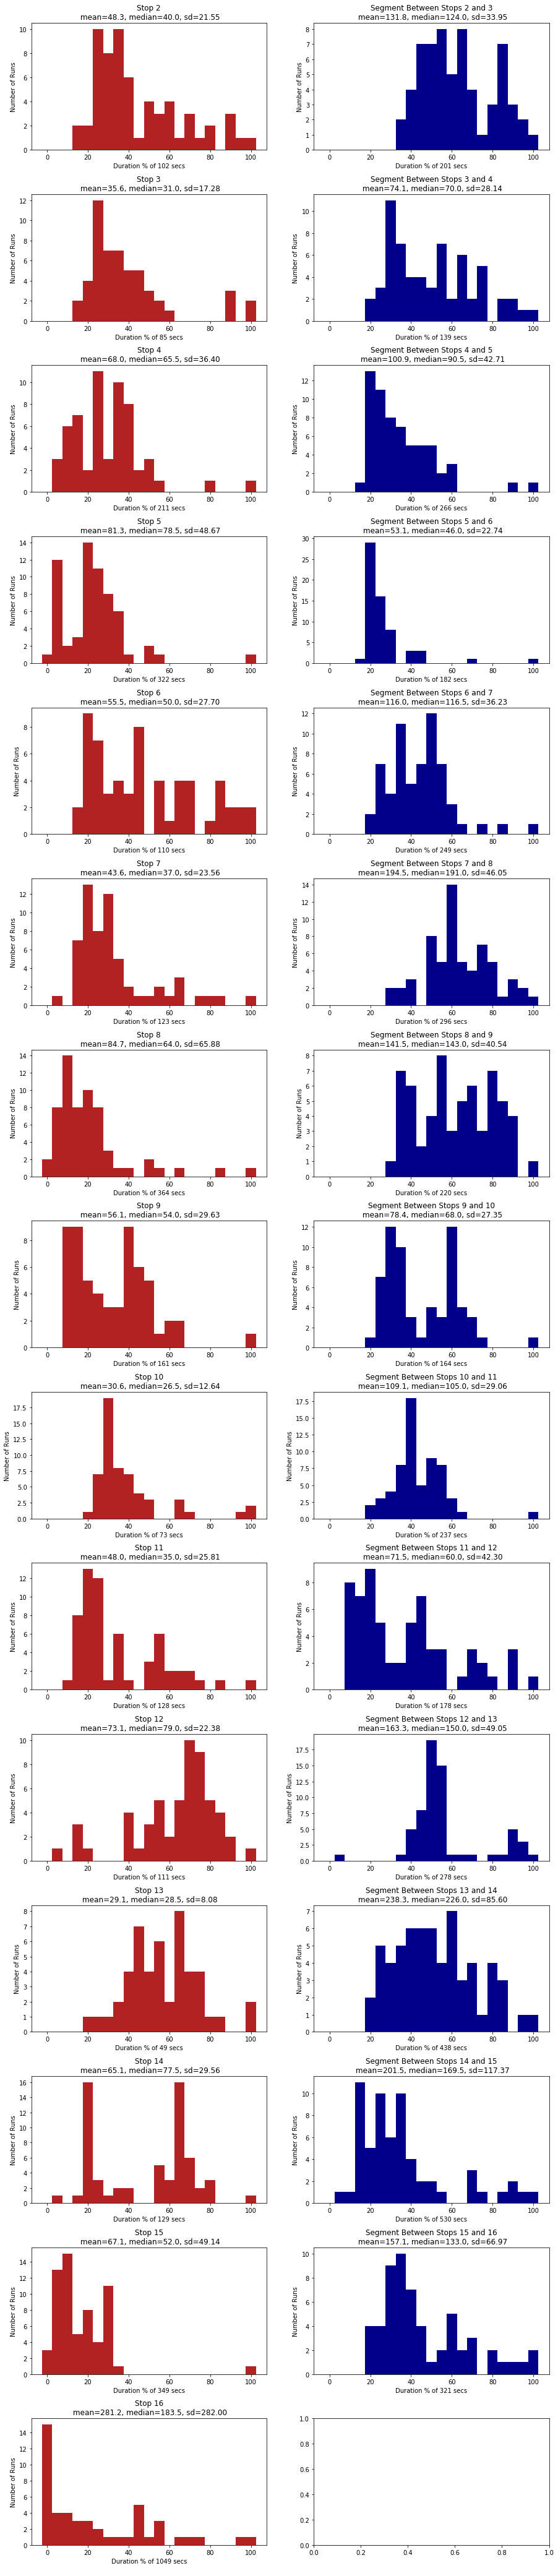

In [122]:
show_segment_hists(segment_durations, "Duration", "secs")

### Speed

The speed is considerably lower inside the stop windows. This suggests that the bus slows down considerably around the stop and that there is often a large dwell time. This can be further corroborated using the bus stationary/bus door open measures below.

Since the distance is relatively constant, we would expect this measure to be distributed very similarly to the above distributions for duration. And they are. 

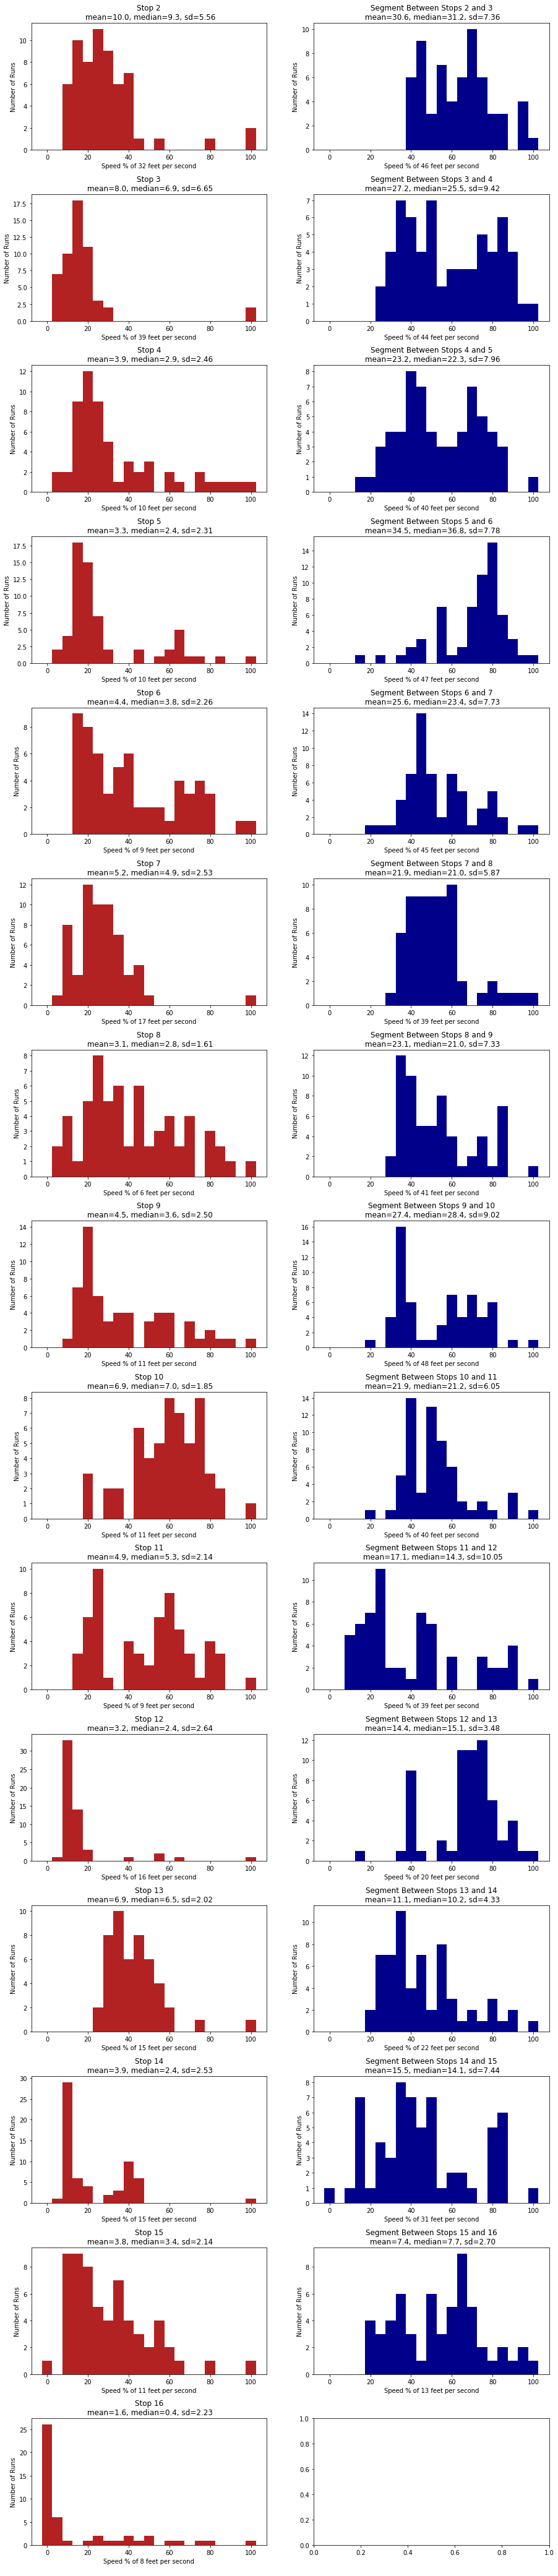

In [123]:
show_segment_hists(segment_speeds, "Speed", "feet per second")

### Time Elapsed with Bus Door Open

As expected (and hoped), the vast majority of data points between stops have a value of zero for this metric. This is good, we wouldn't want the bus to be running between stops with the door open. However there remain segment runs for which the system reports that the door is open momentarily (e.g. for 2 seconds in the segment between stops 9 and 10) or for a very, very long time (e.g. for 97 seconds between stops 5 and 6).

What is going on when the bus reports that the door is open between stops? I am not entirely sure if these are AVL system failures, door sensor failures, or the door is indeed open for all this time (for example due to some type of problem that caused the operator to stop the vehicle mid-route, but the AVL system was still on).

Data cleaning options:
- include only stationary and door open in this metric, and exclude door open while vehicle is moving, and see what happens
- exclude segment runs for which bus door is open any amount of time between stops

More interesting for the purposes of my analysis, however, is the time elapsed with the door open within the stop windows. This, along with the following metric (time elapsed with vehicle stationary), provides a good proxy for dwell time.

Most of the histograms here seem to be normally distributed with a tail skewing the distribution towards a higher mean. The higher-valued observations are likely due to times when there is a longer dwell time due to a high number of passengers getting on and off. Other explanations?

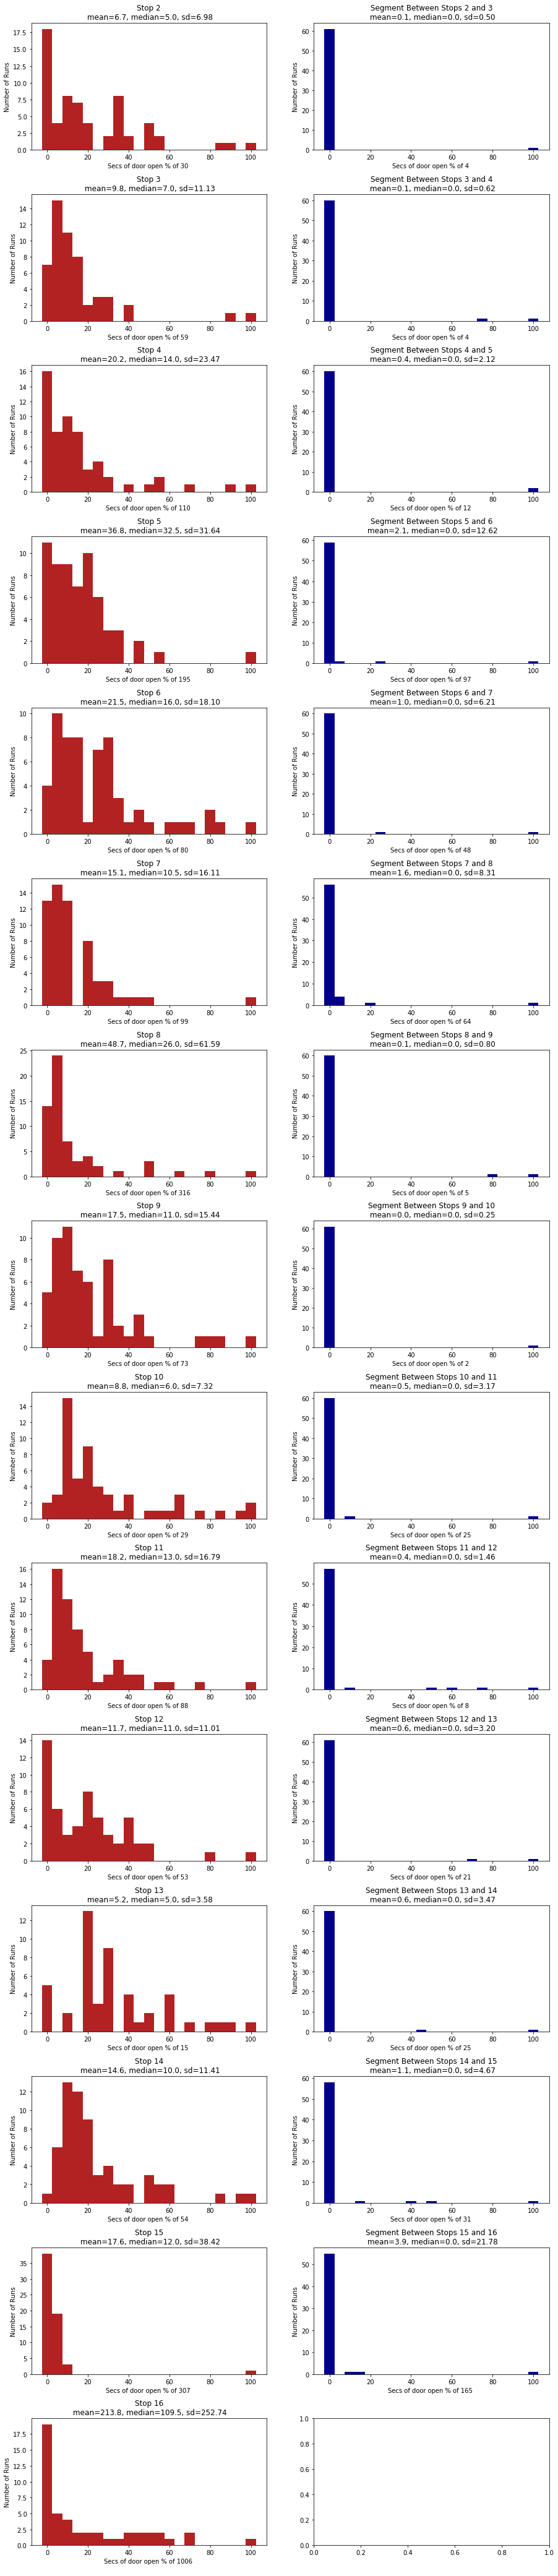

In [124]:
show_segment_hists(segment_door_open, "Secs of door open")

### Time Elapsed while Bus Stationary

Here, predictably, there are non-zero observations both within stop windows and between stop windows. Surprising for me, though, is the fact that the vehicle stationary time is on average much higher between stop windows than within them! Some stops, for example Stop 5, consistently see a higher than average stationary vehicle time, though.

As previously mentioned, this and the previous metric provide a good proxy for dwell time. This one in particular  can help us exclude forms of delay that are not due to dwell time, since the bus is often stationary between two stops. When the stationary time is between stops, we can attribute it to signal delay or road congestion. **How could we distinguish between the two, if we wanted?**

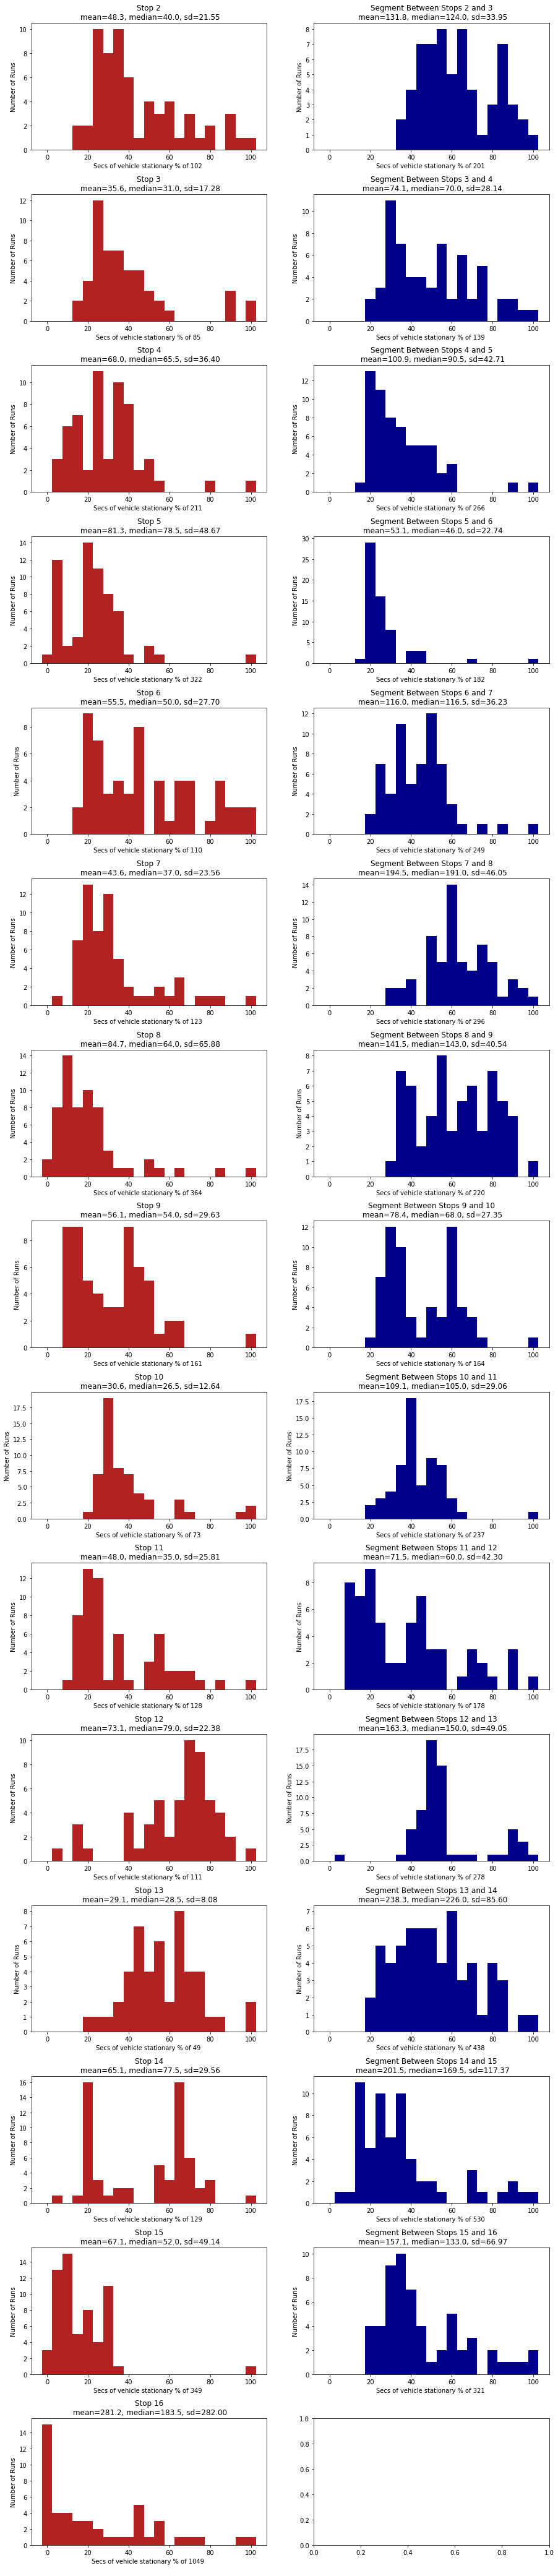

In [125]:
show_segment_hists(segment_durations, "Secs of vehicle stationary")